---
## 1. Configuration de l'Environnement

In [8]:
import torch
from torch import Tensor
import numpy as np
import pandas as pd

print(f"Version de PyTorch: {torch.__version__}")

Version de PyTorch: 2.2.2+cpu


In [9]:
import os
os.environ['TORCH'] = torch.__version__

!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install pyg-lib -f https://data.pyg.org/whl/nightly/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://data.pyg.org/whl/torch-2.2.2+cpu.html
Looking in links: https://data.pyg.org/whl/torch-2.2.2+cpu.html
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://data.pyg.org/whl/torch-2.2.2+cpu.html
Looking in links: https://data.pyg.org/whl/torch-2.2.2+cpu.html
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://data.pyg.org/whl/nightly/torch-2.2.2+cpu.html
Looking in links: https://data.pyg.org/whl/nightly/torch-2.2.2+cpu.html
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/pyg-team/pytorch_geometri

In [10]:
from torch_geometric.data import download_url, extract_zip
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.transforms import RandomLinkSplit, ToUndirected
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, SAGEConv, GATConv, GINConv, EdgeConv
from torch_geometric.nn import global_mean_pool
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score
from torch_geometric.utils import negative_sampling
import matplotlib.pyplot as plt

print("✓ Toutes les bibliothèques sont importées")

✓ Toutes les bibliothèques sont importées


---
## 2. Chargement et Préparation des Données

In [11]:
# Chargement des arêtes
edge_url = "https://raw.githubusercontent.com/lamypark/FlavorGraph/master/input/edges_191120.csv"
edges_df = pd.read_csv(edge_url)

# Filtrer uniquement les relations ingrédient-ingrédient
edges_df = edges_df.iloc[:111355, :]

print(f"Nombre d'arêtes: {len(edges_df)}")
print(edges_df.head())

Nombre d'arêtes: 111355
   id_1  id_2     score  edge_type
0  5063  6083  0.337742  ingr-ingr
1   244  4620  0.093855  ingr-ingr
2  2253  6753  0.107870  ingr-ingr
3  2813  6228  0.092569  ingr-ingr
4  3016  6314  0.123897  ingr-ingr


In [12]:
# Chargement des nœuds
node_url = "https://raw.githubusercontent.com/lamypark/FlavorGraph/master/input/nodes_191120.csv"
nodes_df = pd.read_csv(node_url)

print(f"Nombre de nœuds: {len(nodes_df)}")
print(nodes_df.head())

Nombre de nœuds: 8298
   node_id                    name  id   node_type  is_hub
0        0       1%_fat_buttermilk NaN  ingredient  no_hub
1        1   1%_fat_cottage_cheese NaN  ingredient  no_hub
2        3               10%_cream NaN  ingredient  no_hub
3        4               100%_bran NaN  ingredient  no_hub
4        5  10_inch_flour_tortilla NaN  ingredient  no_hub


In [13]:
# Filtrer les nœuds pertinents (ceux qui apparaissent dans les arêtes)
relevant_node_ids = set(edges_df.id_1.values).union(set(edges_df.id_2.values))
nodes_df = nodes_df[nodes_df['node_id'].isin(relevant_node_ids)]

print(f"Nombre de nœuds après filtrage: {len(nodes_df)}")
print(f"Types de nœuds: {nodes_df.node_type.value_counts()}")

Nombre de nœuds après filtrage: 6653
Types de nœuds: node_type
ingredient    6653
Name: count, dtype: int64


In [14]:
# Initialisation du graphe
flavorGraph = Data()

# Extraction des poids des arêtes
edge_weight = torch.Tensor(edges_df.score.values)

# Extraction des indices de nœuds
node_index = torch.Tensor(nodes_df.node_id.values)

# Création d'un mapping : node_id -> index continu
node_map = dict()
for i in range(len(node_index)):
    node_map[int(node_index[i])] = i

print(f"Nombre de nœuds mappés: {len(node_map)}")
print(f"Exemple de mapping: {list(node_map.items())[:5]}")

Nombre de nœuds mappés: 6653
Exemple de mapping: [(0, 0), (1, 1), (3, 2), (4, 3), (5, 4)]


In [15]:
# Conversion des IDs d'arêtes vers les indices mappés
edge_index = torch.Tensor([
    edges_df.id_1.apply(lambda x: node_map[x]).values,
    edges_df.id_2.apply(lambda x: node_map[x]).values
])

# Construction du graphe
flavorGraph.x = node_index.view(node_index.size(0), -1)  # Features = node_id
flavorGraph.edge_index = edge_index.type(torch.int64)
flavorGraph.edge_weight = edge_weight

# Validation du graphe
flavorGraph.validate(raise_on_error=True)
print("✓ Graphe validé")

# Conversion en graphe non-orienté
flavorGraph = ToUndirected()(flavorGraph)
print(f"✓ Graphe non-orienté: {flavorGraph.is_undirected()}")
print(f"\nStatistiques du graphe:")
print(f"  - Nœuds: {flavorGraph.num_nodes}")
print(f"  - Arêtes: {flavorGraph.num_edges}")
print(f"  - Features: {flavorGraph.num_features}")

✓ Graphe validé
✓ Graphe non-orienté: True

Statistiques du graphe:
  - Nœuds: 6653
  - Arêtes: 222710
  - Features: 1


/tmp/ipykernel_46987/2442971893.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  edge_index = torch.Tensor([


In [16]:
# Split train/val/test
transform = RandomLinkSplit(
    is_undirected=True,
    add_negative_train_samples=False,
    disjoint_train_ratio=0.35
)

train_data, val_data, test_data = transform(flavorGraph)

print("Division des données:")
print(f"  - Train: {train_data.edge_label_index.size(1)} arêtes positives")
print(f"  - Validation: {val_data.edge_label_index.size(1)} arêtes")
print(f"  - Test: {test_data.edge_label_index.size(1)} arêtes")

Division des données:
  - Train: 27282 arêtes positives
  - Validation: 22270 arêtes
  - Test: 44542 arêtes


In [17]:
# Normalisation des features
train_data_norm = train_data.clone()
val_data_norm = val_data.clone()
test_data_norm = test_data.clone()

mean = train_data.x.mean(dim=0, keepdim=True)
std = train_data.x.std(dim=0, keepdim=True)

train_data_norm.x = (train_data.x - mean) / (std + 1e-10)
val_data_norm.x = (val_data.x - mean) / (std + 1e-10)
test_data_norm.x = (test_data.x - mean) / (std + 1e-10)

print(f"Features normalisées:")
print(f"  - Moyenne: {train_data_norm.x.mean():.4f}")
print(f"  - Écart-type: {train_data_norm.x.std():.4f}")

Features normalisées:
  - Moyenne: -0.0000
  - Écart-type: 1.0000


---
## 3. Définition des Modèles

Nous définissons tous les modèles avec une architecture cohérente pour une comparaison équitable.

In [ ]:
# Modèle 1: GCN (baseline)
class Net_GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()

✓ Modèle GCN défini


In [ ]:
# Modèle 2: GraphSAGE
class Net_SAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()

✓ Modèle GraphSAGE défini


In [ ]:
# Modèle 3: GAT
class Net_GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=4, dropout=0.3):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        self.bn1 = nn.BatchNorm1d(hidden_channels * heads)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=dropout)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.dropout = dropout

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        return x

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()

✓ Modèle GAT défini


In [ ]:
# Modèle 4: GIN
class Net_GIN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.3):
        super().__init__()
        
        # Premier MLP pour GINConv
        nn1 = nn.Sequential(
            nn.Linear(in_channels, hidden_channels),
            nn.BatchNorm1d(hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, hidden_channels),
            nn.BatchNorm1d(hidden_channels),
            nn.ReLU()
        )
        self.conv1 = GINConv(nn1, train_eps=False)
        
        # Second MLP pour GINConv
        nn2 = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            nn.BatchNorm1d(hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, out_channels),
            nn.BatchNorm1d(out_channels),
            nn.ReLU()
        )
        self.conv2 = GINConv(nn2, train_eps=False)
        self.dropout = dropout
        
        # Initialisation Xavier
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()

✓ Modèle GIN défini


### Nouveaux Modèles

In [ ]:
# Modèle 5: Hybrid GNN (GCN + GAT)
class Net_Hybrid(torch.nn.Module):
    """Combinaison de GCN et GAT pour capturer différents aspects du graphe"""
    def __init__(self, in_channels, hidden_channels, out_channels, heads=2, dropout=0.3):
        super().__init__()
        
        # Branche GCN
        self.gcn1 = GCNConv(in_channels, hidden_channels)
        self.gcn2 = GCNConv(hidden_channels, hidden_channels)
        
        # Branche GAT
        self.gat1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        self.gat2 = GATConv(hidden_channels * heads, hidden_channels, heads=1, concat=False, dropout=dropout)
        
        # Batch Normalization
        self.bn_gcn = nn.BatchNorm1d(hidden_channels)
        self.bn_gat = nn.BatchNorm1d(hidden_channels)
        
        # Fusion layer
        self.fusion = nn.Linear(hidden_channels * 2, out_channels)
        self.bn_fusion = nn.BatchNorm1d(out_channels)
        
        self.dropout = dropout

    def encode(self, x, edge_index):
        # Branche GCN
        x_gcn = F.relu(self.gcn1(x, edge_index))
        x_gcn = F.dropout(x_gcn, p=self.dropout, training=self.training)
        x_gcn = self.gcn2(x_gcn, edge_index)
        x_gcn = self.bn_gcn(x_gcn)
        
        # Branche GAT
        x_gat = F.relu(self.gat1(x, edge_index))
        x_gat = F.dropout(x_gat, p=self.dropout, training=self.training)
        x_gat = self.gat2(x_gat, edge_index)
        x_gat = self.bn_gat(x_gat)
        
        # Fusion
        x = torch.cat([x_gcn, x_gat], dim=-1)
        x = self.fusion(x)
        x = self.bn_fusion(x)
        return x

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()

✓ Modèle Hybrid GNN défini


In [ ]:
# Modèle 6: EdgeConv
class Net_EdgeConv(torch.nn.Module):
    """EdgeConv: convolution qui opère sur les features des arêtes"""
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.3):
        super().__init__()
        
        # EdgeConv layers avec MLPs
        nn1 = nn.Sequential(
            nn.Linear(2 * in_channels, hidden_channels),
            nn.BatchNorm1d(hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, hidden_channels),
        )
        self.conv1 = EdgeConv(nn1, aggr='max')
        
        nn2 = nn.Sequential(
            nn.Linear(2 * hidden_channels, hidden_channels),
            nn.BatchNorm1d(hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, out_channels),
        )
        self.conv2 = EdgeConv(nn2, aggr='max')
        
        self.bn1 = nn.BatchNorm1d(hidden_channels)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.dropout = dropout

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        return x

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()

✓ Modèle EdgeConv défini


In [ ]:
# Modèle 7: Deeper GCN avec connexions résiduelles
class Net_DeeperGCN(torch.nn.Module):
    """GCN plus profond avec connexions résiduelles pour capturer des patterns complexes"""
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.3):
        super().__init__()
        
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, out_channels)
        
        self.bn1 = nn.BatchNorm1d(hidden_channels)
        self.bn2 = nn.BatchNorm1d(hidden_channels)
        self.bn3 = nn.BatchNorm1d(hidden_channels)
        self.bn4 = nn.BatchNorm1d(out_channels)
        
        # Skip connections
        self.skip1 = nn.Linear(hidden_channels, hidden_channels)
        self.skip2 = nn.Linear(hidden_channels, hidden_channels)
        
        self.dropout = dropout

    def encode(self, x, edge_index):
        # Layer 1
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        identity = x
        
        # Layer 2 with skip
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x + self.skip1(identity))  # Residual connection
        x = F.dropout(x, p=self.dropout, training=self.training)
        identity = x
        
        # Layer 3 with skip
        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.relu(x + self.skip2(identity))  # Residual connection
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Layer 4
        x = self.conv4(x, edge_index)
        x = self.bn4(x)
        return x

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()

✓ Modèle Deeper GCN défini


---
## 4. Fonctions d'Entraînement et d'Évaluation

In [ ]:
def train_with_clipping(model, optimizer, criterion, data):
    """Fonction d'entraînement avec gradient clipping"""
    model.train()
    optimizer.zero_grad()
    
    # Encodage du graphe
    z = model.encode(data.x, data.edge_index)

    # Échantillonnage négatif
    neg_edge_index = negative_sampling(
        edge_index=data.edge_index,
        num_nodes=data.num_nodes,
        num_neg_samples=data.edge_label_index.size(1),
        method='sparse'
    )

    # Concaténation arêtes positives + négatives
    edge_label_index = torch.cat([data.edge_label_index, neg_edge_index], dim=-1)
    edge_label = torch.cat([
        data.edge_label,
        data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    # Prédiction et calcul de la loss
    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    
    # Backpropagation
    loss.backward()
    
    # Gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    
    optimizer.step()
    return loss.item()


@torch.no_grad()
def test_model(model, data):
    """Évalue le modèle avec la métrique ROC-AUC"""
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    
    # Calcul ROC-AUC
    y = data.edge_label.cpu().numpy()
    pred = out.cpu().numpy()
    return roc_auc_score(y, pred)


def train_model(model_name, model, train_data, val_data, test_data, 
                lr=0.001, epochs=150, verbose=True):
    """Entraîne un modèle et retourne les métriques"""
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    
    validation_metrics = []
    best_val_auc = final_test_auc = 0
    
    if verbose:
        print(f"\n{'='*60}")
        print(f"Entraînement de {model_name}")
        print(f"{'='*60}")
        print(f"Paramètres: {sum(p.numel() for p in model.parameters()):,}")
        print(f"Learning rate: {lr}")
        print(f"Epochs: {epochs}\n")
    
    for epoch in range(1, epochs + 1):
        loss = train_with_clipping(model, optimizer, criterion, train_data)
        val_auc = test_model(model, val_data)
        test_auc = test_model(model, test_data)
        
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            final_test_auc = test_auc
        
        validation_metrics.append([val_auc, test_auc])
        
        if verbose and (epoch % 10 == 0 or epoch == 1):
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, Test: {test_auc:.4f}')
    
    if verbose:
        print(f'\nMeilleur Test AUC: {final_test_auc:.4f}')
        print(f"{'='*60}\n")
    
    return validation_metrics, final_test_auc, model

✓ Fonctions d'entraînement définies


---
## 5. Entraînement de Tous les Modèles

In [26]:
# Modèle 1: GCN
model_gcn = Net_GCN(flavorGraph.num_features, 128, 64)
metrics_gcn, auc_gcn, model_gcn = train_model(
    "GCN", model_gcn, train_data_norm, val_data_norm, test_data_norm
)


Entraînement de GCN
Paramètres: 8,512
Learning rate: 0.001
Epochs: 150

Epoch: 001, Loss: 0.6902, Val: 0.8517, Test: 0.8629
Epoch: 001, Loss: 0.6902, Val: 0.8517, Test: 0.8629
Epoch: 010, Loss: 0.6702, Val: 0.8838, Test: 0.8928
Epoch: 010, Loss: 0.6702, Val: 0.8838, Test: 0.8928
Epoch: 020, Loss: 0.6511, Val: 0.8973, Test: 0.9039
Epoch: 020, Loss: 0.6511, Val: 0.8973, Test: 0.9039
Epoch: 030, Loss: 0.6378, Val: 0.9024, Test: 0.9077
Epoch: 030, Loss: 0.6378, Val: 0.9024, Test: 0.9077
Epoch: 040, Loss: 0.6308, Val: 0.9069, Test: 0.9108
Epoch: 040, Loss: 0.6308, Val: 0.9069, Test: 0.9108
Epoch: 050, Loss: 0.6238, Val: 0.9097, Test: 0.9125
Epoch: 050, Loss: 0.6238, Val: 0.9097, Test: 0.9125
Epoch: 060, Loss: 0.6218, Val: 0.9117, Test: 0.9137
Epoch: 060, Loss: 0.6218, Val: 0.9117, Test: 0.9137
Epoch: 070, Loss: 0.6167, Val: 0.9137, Test: 0.9149
Epoch: 070, Loss: 0.6167, Val: 0.9137, Test: 0.9149
Epoch: 080, Loss: 0.6143, Val: 0.9155, Test: 0.9160
Epoch: 080, Loss: 0.6143, Val: 0.9155, Test

In [27]:
# Modèle 2: GraphSAGE
model_sage = Net_SAGE(flavorGraph.num_features, 128, 64)
metrics_sage, auc_sage, model_sage = train_model(
    "GraphSAGE", model_sage, train_data_norm, val_data_norm, test_data_norm
)


Entraînement de GraphSAGE
Paramètres: 16,832
Learning rate: 0.001
Epochs: 150

Epoch: 001, Loss: 3.0661, Val: 0.5035, Test: 0.5153
Epoch: 001, Loss: 3.0661, Val: 0.5035, Test: 0.5153
Epoch: 010, Loss: 0.7228, Val: 0.5432, Test: 0.5576
Epoch: 010, Loss: 0.7228, Val: 0.5432, Test: 0.5576
Epoch: 020, Loss: 0.6912, Val: 0.5625, Test: 0.5684
Epoch: 020, Loss: 0.6912, Val: 0.5625, Test: 0.5684
Epoch: 030, Loss: 0.6777, Val: 0.6061, Test: 0.6118
Epoch: 030, Loss: 0.6777, Val: 0.6061, Test: 0.6118
Epoch: 040, Loss: 0.6712, Val: 0.6395, Test: 0.6455
Epoch: 040, Loss: 0.6712, Val: 0.6395, Test: 0.6455
Epoch: 050, Loss: 0.6654, Val: 0.6673, Test: 0.6720
Epoch: 050, Loss: 0.6654, Val: 0.6673, Test: 0.6720
Epoch: 060, Loss: 0.6613, Val: 0.6857, Test: 0.6912
Epoch: 060, Loss: 0.6613, Val: 0.6857, Test: 0.6912
Epoch: 070, Loss: 0.6570, Val: 0.7006, Test: 0.7066
Epoch: 070, Loss: 0.6570, Val: 0.7006, Test: 0.7066
Epoch: 080, Loss: 0.6551, Val: 0.7087, Test: 0.7150
Epoch: 080, Loss: 0.6551, Val: 0.708

In [28]:
# Modèle 3: GAT
model_gat = Net_GAT(flavorGraph.num_features, 128, 64, heads=4, dropout=0.3)
metrics_gat, auc_gat, model_gat = train_model(
    "GAT", model_gat, train_data_norm, val_data_norm, test_data_norm
)


Entraînement de GAT
Paramètres: 36,160
Learning rate: 0.001
Epochs: 150

Epoch: 001, Loss: 5.5580, Val: 0.3392, Test: 0.3345
Epoch: 001, Loss: 5.5580, Val: 0.3392, Test: 0.3345
Epoch: 010, Loss: 1.1696, Val: 0.3272, Test: 0.3205
Epoch: 010, Loss: 1.1696, Val: 0.3272, Test: 0.3205
Epoch: 020, Loss: 0.9248, Val: 0.3226, Test: 0.3165
Epoch: 020, Loss: 0.9248, Val: 0.3226, Test: 0.3165
Epoch: 030, Loss: 0.8801, Val: 0.3129, Test: 0.3108
Epoch: 030, Loss: 0.8801, Val: 0.3129, Test: 0.3108
Epoch: 040, Loss: 0.8183, Val: 0.3353, Test: 0.3298
Epoch: 040, Loss: 0.8183, Val: 0.3353, Test: 0.3298
Epoch: 050, Loss: 0.8289, Val: 0.3950, Test: 0.3804
Epoch: 050, Loss: 0.8289, Val: 0.3950, Test: 0.3804
Epoch: 060, Loss: 0.7701, Val: 0.4866, Test: 0.4665
Epoch: 060, Loss: 0.7701, Val: 0.4866, Test: 0.4665
Epoch: 070, Loss: 0.8153, Val: 0.5250, Test: 0.5048
Epoch: 070, Loss: 0.8153, Val: 0.5250, Test: 0.5048
Epoch: 080, Loss: 0.7934, Val: 0.4007, Test: 0.3684
Epoch: 080, Loss: 0.7934, Val: 0.4007, Tes

In [29]:
# Modèle 4: GIN
model_gin = Net_GIN(flavorGraph.num_features, 128, 64, dropout=0.3)
metrics_gin, auc_gin, model_gin = train_model(
    "GIN", model_gin, train_data_norm, val_data_norm, test_data_norm, lr=0.0005
)


Entraînement de GIN
Paramètres: 42,432
Learning rate: 0.0005
Epochs: 150

Epoch: 001, Loss: 3.5855, Val: 0.5718, Test: 0.5549
Epoch: 001, Loss: 3.5855, Val: 0.5718, Test: 0.5549
Epoch: 010, Loss: 2.1126, Val: 0.7582, Test: 0.7266
Epoch: 010, Loss: 2.1126, Val: 0.7582, Test: 0.7266
Epoch: 020, Loss: 1.3240, Val: 0.8427, Test: 0.8298
Epoch: 020, Loss: 1.3240, Val: 0.8427, Test: 0.8298
Epoch: 030, Loss: 1.4062, Val: 0.8622, Test: 0.8632
Epoch: 030, Loss: 1.4062, Val: 0.8622, Test: 0.8632
Epoch: 040, Loss: 1.1087, Val: 0.8289, Test: 0.8457
Epoch: 040, Loss: 1.1087, Val: 0.8289, Test: 0.8457
Epoch: 050, Loss: 1.0867, Val: 0.7999, Test: 0.8290
Epoch: 050, Loss: 1.0867, Val: 0.7999, Test: 0.8290
Epoch: 060, Loss: 1.0009, Val: 0.8001, Test: 0.8242
Epoch: 060, Loss: 1.0009, Val: 0.8001, Test: 0.8242
Epoch: 070, Loss: 0.9489, Val: 0.8229, Test: 0.8405
Epoch: 070, Loss: 0.9489, Val: 0.8229, Test: 0.8405
Epoch: 080, Loss: 0.9069, Val: 0.8269, Test: 0.8411
Epoch: 080, Loss: 0.9069, Val: 0.8269, Te

In [30]:
# Modèle 5: Hybrid GNN
model_hybrid = Net_Hybrid(flavorGraph.num_features, 128, 64, heads=2, dropout=0.3)
metrics_hybrid, auc_hybrid, model_hybrid = train_model(
    "Hybrid GNN", model_hybrid, train_data_norm, val_data_norm, test_data_norm
)


Entraînement de Hybrid GNN
Paramètres: 68,032
Learning rate: 0.001
Epochs: 150

Epoch: 001, Loss: 3.7970, Val: 0.2598, Test: 0.2498
Epoch: 001, Loss: 3.7970, Val: 0.2598, Test: 0.2498
Epoch: 010, Loss: 1.1138, Val: 0.6033, Test: 0.6177
Epoch: 010, Loss: 1.1138, Val: 0.6033, Test: 0.6177
Epoch: 020, Loss: 0.9888, Val: 0.8162, Test: 0.8375
Epoch: 020, Loss: 0.9888, Val: 0.8162, Test: 0.8375
Epoch: 030, Loss: 0.9309, Val: 0.8139, Test: 0.8468
Epoch: 030, Loss: 0.9309, Val: 0.8139, Test: 0.8468
Epoch: 040, Loss: 0.9230, Val: 0.8620, Test: 0.8792
Epoch: 040, Loss: 0.9230, Val: 0.8620, Test: 0.8792
Epoch: 050, Loss: 0.8632, Val: 0.8642, Test: 0.8846
Epoch: 050, Loss: 0.8632, Val: 0.8642, Test: 0.8846
Epoch: 060, Loss: 0.8218, Val: 0.8831, Test: 0.8964
Epoch: 060, Loss: 0.8218, Val: 0.8831, Test: 0.8964
Epoch: 070, Loss: 0.8045, Val: 0.9023, Test: 0.9111
Epoch: 070, Loss: 0.8045, Val: 0.9023, Test: 0.9111
Epoch: 080, Loss: 0.8047, Val: 0.9099, Test: 0.9157
Epoch: 080, Loss: 0.8047, Val: 0.90

In [31]:
# Modèle 6: EdgeConv
model_edgeconv = Net_EdgeConv(flavorGraph.num_features, 128, 64, dropout=0.3)
metrics_edgeconv, auc_edgeconv, model_edgeconv = train_model(
    "EdgeConv", model_edgeconv, train_data_norm, val_data_norm, test_data_norm
)


Entraînement de EdgeConv
Paramètres: 58,944
Learning rate: 0.001
Epochs: 150

Epoch: 001, Loss: 6.1085, Val: 0.6037, Test: 0.5989
Epoch: 001, Loss: 6.1085, Val: 0.6037, Test: 0.5989
Epoch: 010, Loss: 3.3981, Val: 0.5385, Test: 0.5565
Epoch: 010, Loss: 3.3981, Val: 0.5385, Test: 0.5565
Epoch: 020, Loss: 2.8269, Val: 0.5966, Test: 0.6117
Epoch: 020, Loss: 2.8269, Val: 0.5966, Test: 0.6117
Epoch: 030, Loss: 2.5071, Val: 0.6118, Test: 0.6202
Epoch: 030, Loss: 2.5071, Val: 0.6118, Test: 0.6202
Epoch: 040, Loss: 2.1780, Val: 0.5998, Test: 0.6030
Epoch: 040, Loss: 2.1780, Val: 0.5998, Test: 0.6030
Epoch: 050, Loss: 1.8426, Val: 0.5729, Test: 0.5768
Epoch: 050, Loss: 1.8426, Val: 0.5729, Test: 0.5768
Epoch: 060, Loss: 1.6610, Val: 0.5477, Test: 0.5507
Epoch: 060, Loss: 1.6610, Val: 0.5477, Test: 0.5507
Epoch: 070, Loss: 1.5152, Val: 0.5411, Test: 0.5470
Epoch: 070, Loss: 1.5152, Val: 0.5411, Test: 0.5470
Epoch: 080, Loss: 1.3790, Val: 0.5714, Test: 0.5845
Epoch: 080, Loss: 1.3790, Val: 0.5714

In [32]:
# Modèle 7: Deeper GCN
model_deepergcn = Net_DeeperGCN(flavorGraph.num_features, 128, 64, dropout=0.3)
metrics_deepergcn, auc_deepergcn, model_deepergcn = train_model(
    "Deeper GCN", model_deepergcn, train_data_norm, val_data_norm, test_data_norm
)


Entraînement de Deeper GCN
Paramètres: 75,456
Learning rate: 0.001
Epochs: 150

Epoch: 001, Loss: 1.7101, Val: 0.8976, Test: 0.8930
Epoch: 001, Loss: 1.7101, Val: 0.8976, Test: 0.8930
Epoch: 010, Loss: 0.8306, Val: 0.9110, Test: 0.9108
Epoch: 010, Loss: 0.8306, Val: 0.9110, Test: 0.9108
Epoch: 020, Loss: 0.7686, Val: 0.8806, Test: 0.8759
Epoch: 020, Loss: 0.7686, Val: 0.8806, Test: 0.8759
Epoch: 030, Loss: 0.7327, Val: 0.8418, Test: 0.8343
Epoch: 030, Loss: 0.7327, Val: 0.8418, Test: 0.8343
Epoch: 040, Loss: 0.7308, Val: 0.8335, Test: 0.8238
Epoch: 040, Loss: 0.7308, Val: 0.8335, Test: 0.8238
Epoch: 050, Loss: 0.7390, Val: 0.8342, Test: 0.8217
Epoch: 050, Loss: 0.7390, Val: 0.8342, Test: 0.8217
Epoch: 060, Loss: 0.7364, Val: 0.8510, Test: 0.8386
Epoch: 060, Loss: 0.7364, Val: 0.8510, Test: 0.8386
Epoch: 070, Loss: 0.6684, Val: 0.8827, Test: 0.8748
Epoch: 070, Loss: 0.6684, Val: 0.8827, Test: 0.8748
Epoch: 080, Loss: 0.6653, Val: 0.8837, Test: 0.8767
Epoch: 080, Loss: 0.6653, Val: 0.88

---
## 6. Comparaison des Résultats

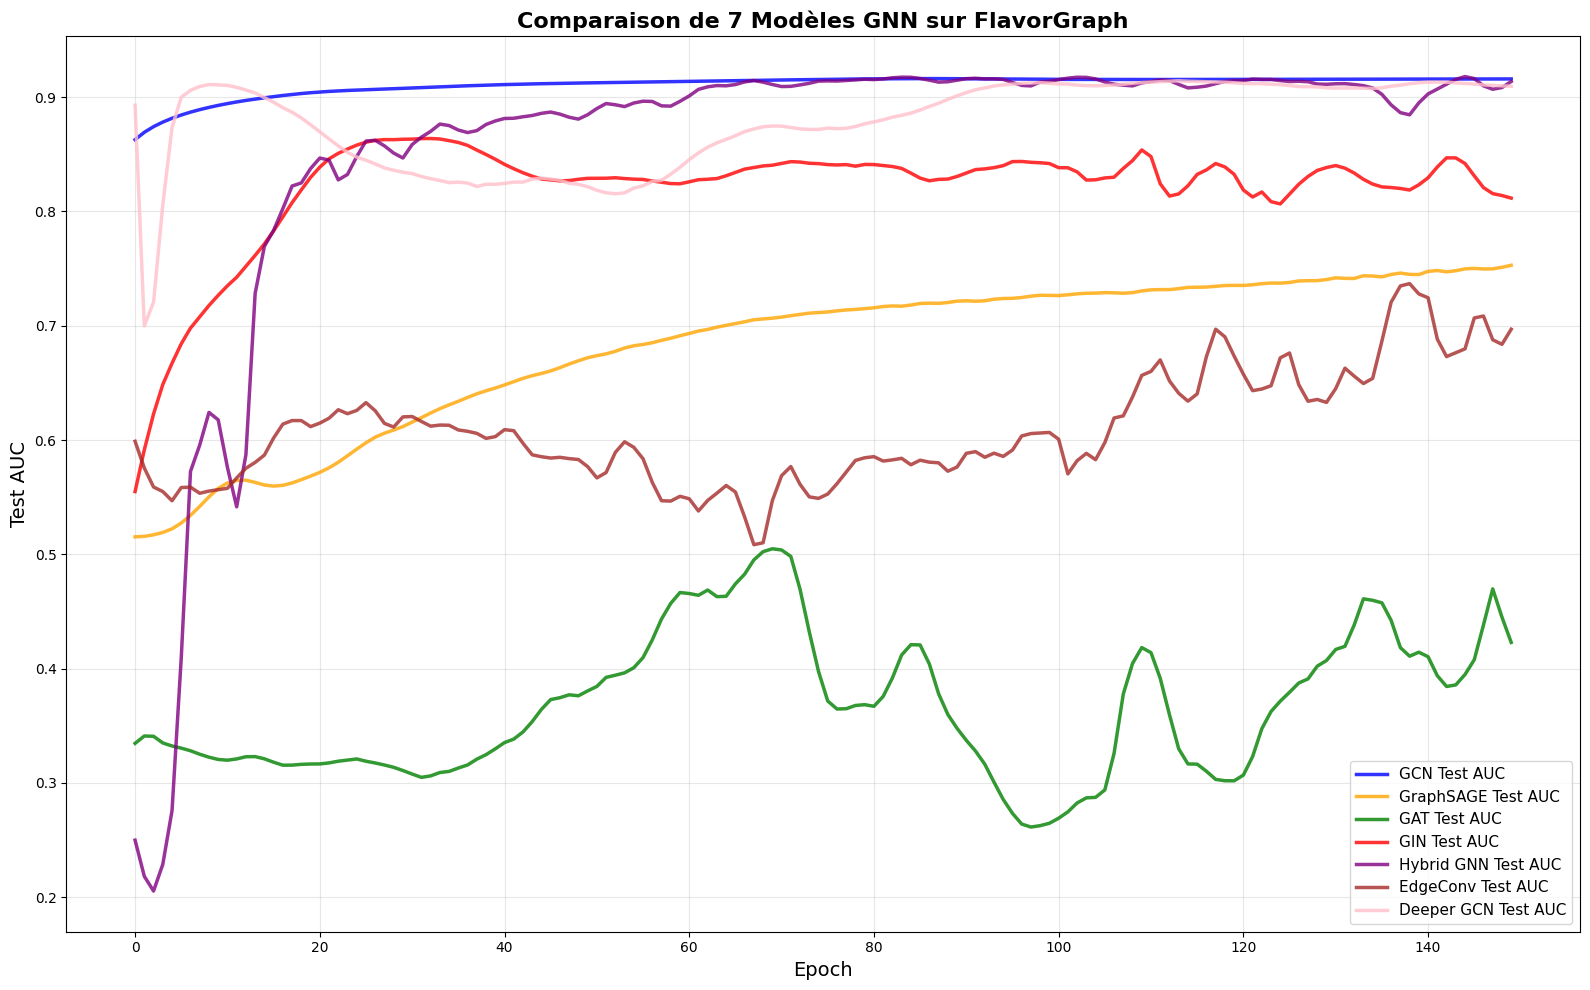

In [33]:
# Visualisation comparative
plt.figure(figsize=(16, 10))

models_data = [
    ("GCN", metrics_gcn, 'blue'),
    ("GraphSAGE", metrics_sage, 'orange'),
    ("GAT", metrics_gat, 'green'),
    ("GIN", metrics_gin, 'red'),
    ("Hybrid GNN", metrics_hybrid, 'purple'),
    ("EdgeConv", metrics_edgeconv, 'brown'),
    ("Deeper GCN", metrics_deepergcn, 'pink'),
]

for name, metrics, color in models_data:
    plt.plot(np.arange(len(metrics)), 
             np.array(metrics)[:, 1], 
             label=f'{name} Test AUC', 
             linewidth=2.5,
             alpha=0.8,
             color=color)

plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Test AUC', fontsize=14)
plt.title('Comparaison de 7 Modèles GNN sur FlavorGraph', fontsize=16, fontweight='bold')
plt.legend(fontsize=11, loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [34]:
# Tableau récapitulatif
results = {
    'GCN': auc_gcn,
    'GraphSAGE': auc_sage,
    'GAT': auc_gat,
    'GIN': auc_gin,
    'Hybrid GNN': auc_hybrid,
    'EdgeConv': auc_edgeconv,
    'Deeper GCN': auc_deepergcn,
}

print("\n" + "="*70)
print("RÉSULTATS FINAUX - COMPARAISON DE 7 MODÈLES GNN")
print("="*70)

# Trier par performance
sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)

print(f"\n{'Rang':<6} {'Modèle':<20} {'Test AUC':<12} {'Amélioration':<15}")
print("-"*70)

baseline_auc = results['GCN']
for rank, (model_name, auc) in enumerate(sorted_results, 1):
    improvement = ((auc - baseline_auc) / baseline_auc) * 100
    improvement_str = f"+{improvement:.2f}%" if improvement > 0 else f"{improvement:.2f}%"
    print(f"{rank:<6} {model_name:<20} {auc:.4f}      {improvement_str}")

print("="*70)
best_model = sorted_results[0][0]
best_auc = sorted_results[0][1]
print(f"\n🏆 Meilleur modèle: {best_model} avec un Test AUC de {best_auc:.4f}")
print(f"   Amélioration vs GCN baseline: +{((best_auc - baseline_auc) / baseline_auc) * 100:.2f}%")
print("="*70)


RÉSULTATS FINAUX - COMPARAISON DE 7 MODÈLES GNN

Rang   Modèle               Test AUC     Amélioration   
----------------------------------------------------------------------
1      Hybrid GNN           0.9180      +0.19%
2      GCN                  0.9163      0.00%
3      Deeper GCN           0.9139      -0.25%
4      GIN                  0.8628      -5.83%
5      GraphSAGE            0.7529      -17.83%
6      EdgeConv             0.7369      -19.58%
7      GAT                  0.5048      -44.90%

🏆 Meilleur modèle: Hybrid GNN avec un Test AUC de 0.9180
   Amélioration vs GCN baseline: +0.19%


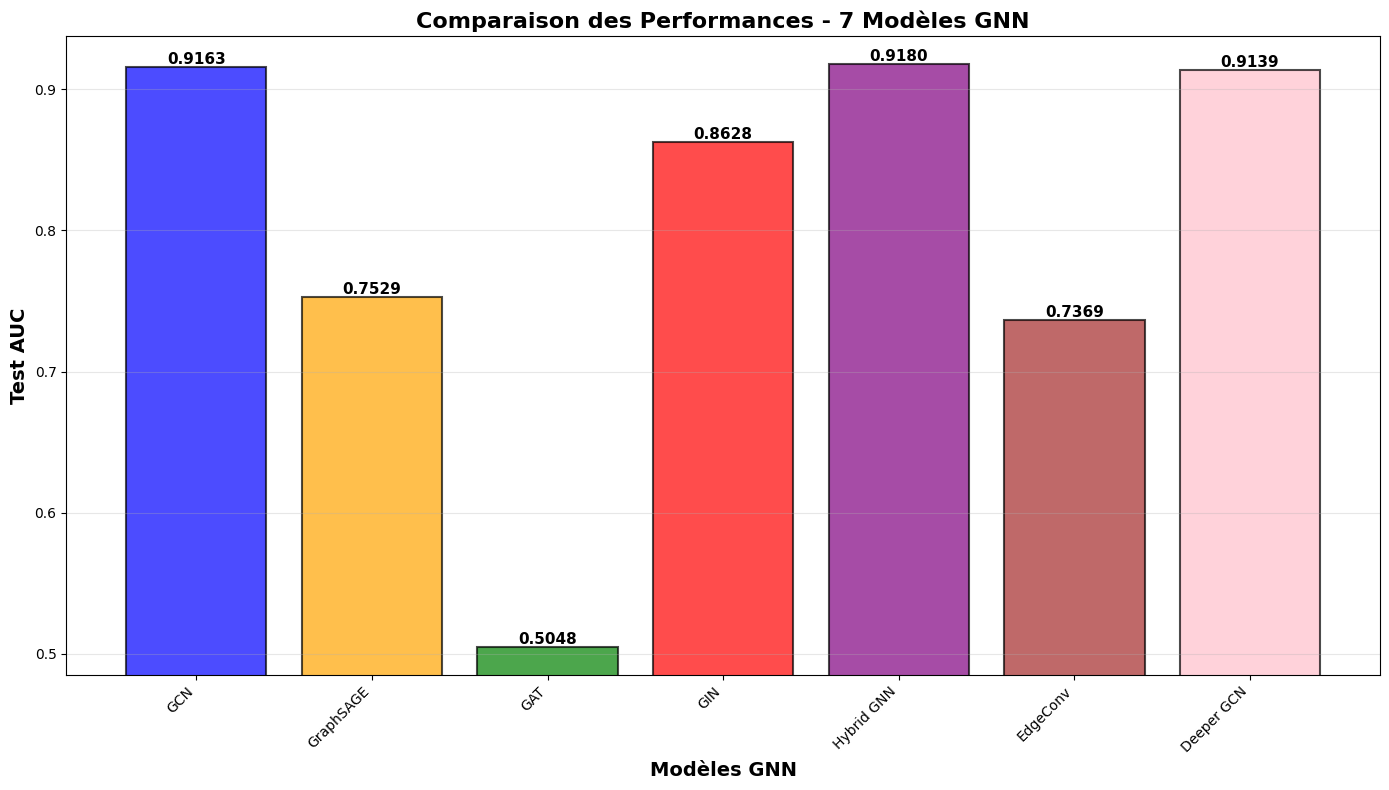

In [35]:
# Diagramme en barres pour comparaison visuelle
plt.figure(figsize=(14, 8))

model_names = list(results.keys())
aucs = list(results.values())
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink']

bars = plt.bar(model_names, aucs, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)

# Ajouter les valeurs sur les barres
for bar, auc in zip(bars, aucs):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{auc:.4f}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.xlabel('Modèles GNN', fontsize=14, fontweight='bold')
plt.ylabel('Test AUC', fontsize=14, fontweight='bold')
plt.title('Comparaison des Performances - 7 Modèles GNN', fontsize=16, fontweight='bold')
plt.ylim([min(aucs) - 0.02, max(aucs) + 0.02])
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

---
## 7. Analyse Détaillée par Modèle

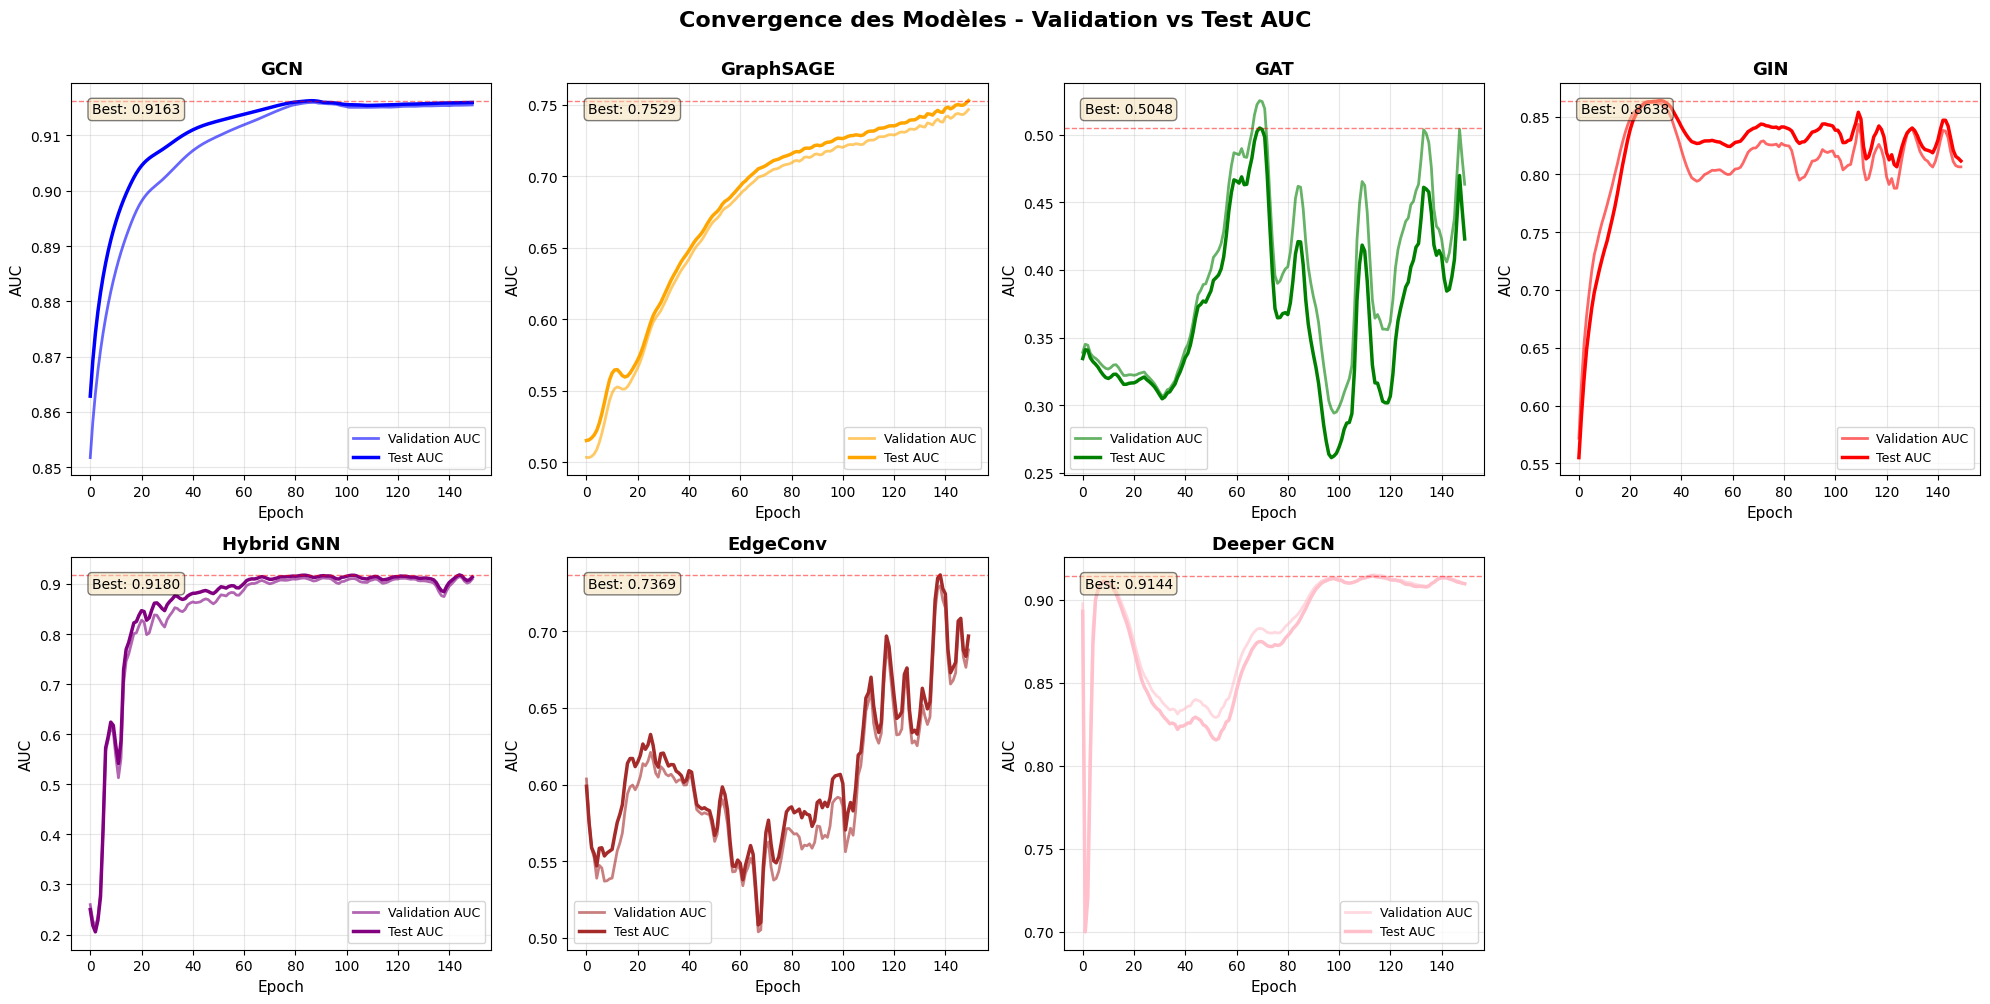

In [36]:
# Analyse de la convergence
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, (name, metrics, color) in enumerate(models_data):
    ax = axes[idx]
    metrics_array = np.array(metrics)
    
    ax.plot(metrics_array[:, 0], label='Validation AUC', color=color, alpha=0.6, linewidth=2)
    ax.plot(metrics_array[:, 1], label='Test AUC', color=color, linewidth=2.5)
    
    ax.set_title(f'{name}', fontsize=13, fontweight='bold')
    ax.set_xlabel('Epoch', fontsize=11)
    ax.set_ylabel('AUC', fontsize=11)
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)
    
    # Afficher le meilleur score
    best_test = metrics_array[:, 1].max()
    ax.axhline(y=best_test, color='red', linestyle='--', alpha=0.5, linewidth=1)
    ax.text(0.05, 0.95, f'Best: {best_test:.4f}', 
            transform=ax.transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Masquer le dernier subplot vide
axes[-1].axis('off')

plt.suptitle('Convergence des Modèles - Validation vs Test AUC', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()


ANALYSE: Nombre de Paramètres vs Performance

Modèle               Paramètres      Test AUC     AUC/1k params
------------------------------------------------------------
GCN                         8,512   0.9163      0.107645
GraphSAGE                  16,832   0.7529      0.044730
GAT                        36,160   0.5048      0.013961
GIN                        42,432   0.8628      0.020334
Hybrid GNN                 68,032   0.9180      0.013494
EdgeConv                   58,944   0.7369      0.012501
Deeper GCN                 75,456   0.9139      0.012112


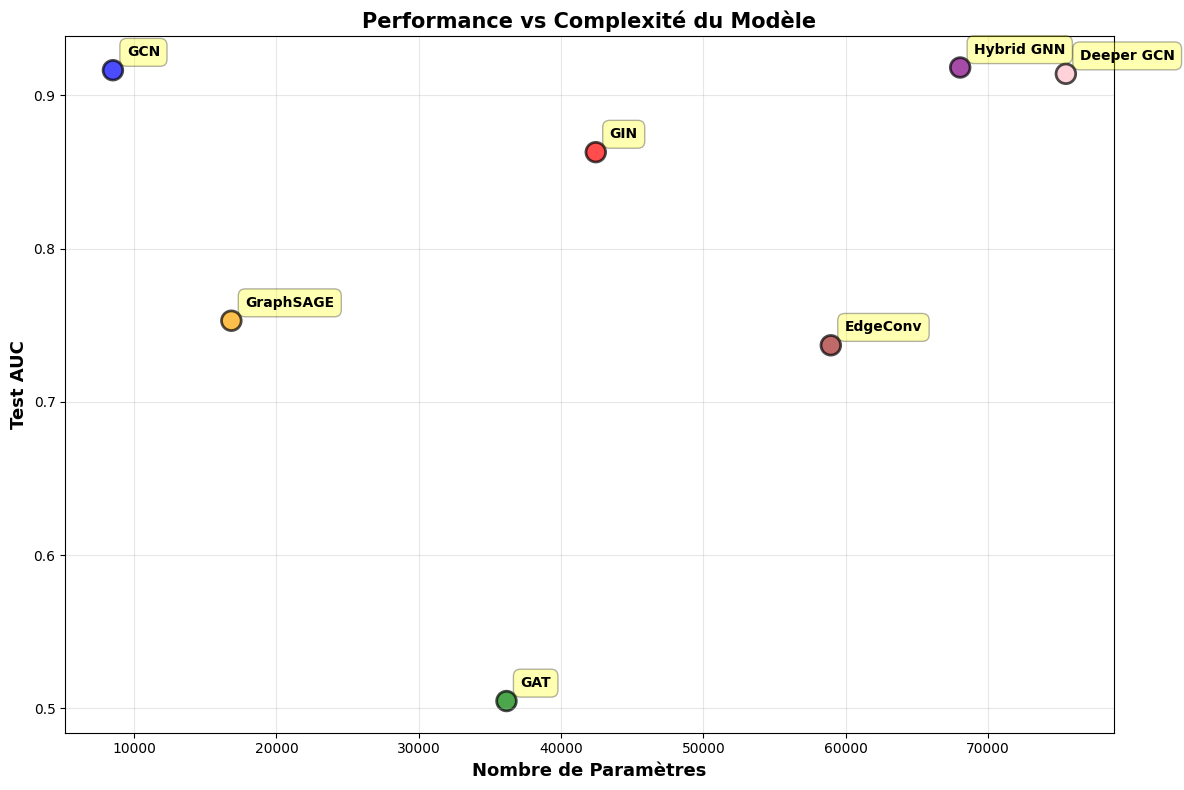

In [37]:
# Comparaison nombre de paramètres vs performance
model_list = [
    model_gcn, model_sage, model_gat, model_gin, 
    model_hybrid, model_edgeconv, model_deepergcn
]

params = [sum(p.numel() for p in m.parameters()) for m in model_list]

print("\n" + "="*60)
print("ANALYSE: Nombre de Paramètres vs Performance")
print("="*60)
print(f"\n{'Modèle':<20} {'Paramètres':<15} {'Test AUC':<12} {'AUC/1k params'}")
print("-"*60)

for name, param_count, auc in zip(model_names, params, aucs):
    efficiency = auc / (param_count / 1000)
    print(f"{name:<20} {param_count:>12,}   {auc:.4f}      {efficiency:.6f}")

print("="*60)

# Graphique scatter
plt.figure(figsize=(12, 8))
plt.scatter(params, aucs, c=colors, s=200, alpha=0.7, edgecolors='black', linewidth=2)

for i, name in enumerate(model_names):
    plt.annotate(name, (params[i], aucs[i]), 
                xytext=(10, 10), textcoords='offset points',
                fontsize=10, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.3))

plt.xlabel('Nombre de Paramètres', fontsize=13, fontweight='bold')
plt.ylabel('Test AUC', fontsize=13, fontweight='bold')
plt.title('Performance vs Complexité du Modèle', fontsize=15, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

---
## 8. Génération de Recettes

Testons les modèles pour générer des suggestions d'ingrédients.

In [38]:
def generate_recipe(model, start_ingredient, num_ingredients=5):
    """Génère une recette à partir d'un ingrédient de départ"""
    model.eval()
    with torch.no_grad():
        z = model.encode(test_data_norm.x, test_data_norm.edge_index)
        probs = z @ z.t()
    
    # Trouver l'index de l'ingrédient
    start_idx = nodes_df[nodes_df['name'] == start_ingredient].index[0]
    
    recipe = [start_ingredient]
    current_idx = start_idx
    
    for _ in range(num_ingredients - 1):
        # Top 10 ingrédients les plus compatibles
        top_indices = probs[current_idx].topk(15).indices.cpu().numpy()
        
        # Choisir aléatoirement parmi les top (éviter le même ingrédient)
        for idx in top_indices:
            candidate = nodes_df.iloc[idx]['name']
            if candidate not in recipe:
                recipe.append(candidate)
                current_idx = idx
                break
    
    return recipe


# Test avec différents modèles
test_ingredients = ['tomato', 'chicken', 'basil']

print("\n" + "="*70)
print("GÉNÉRATION DE RECETTES PAR MODÈLE")
print("="*70)

for start_ing in test_ingredients:
    print(f"\n🍳 Ingrédient de départ: {start_ing.upper()}")
    print("-" * 70)
    
    for name, model in zip(model_names[:5], [model_gcn, model_sage, model_gat, model_gin, model_hybrid]):
        try:
            recipe = generate_recipe(model, start_ing, num_ingredients=6)
            print(f"\n{name:15s}: {' → '.join(recipe)}")
        except:
            print(f"\n{name:15s}: Ingrédient non trouvé")
    
    print()


GÉNÉRATION DE RECETTES PAR MODÈLE

🍳 Ingrédient de départ: TOMATO
----------------------------------------------------------------------

GCN            : tomato → onion → garlic_clove → water → egg → sugar

GraphSAGE      : tomato → rubbing_alcohol → piloncillo → dried_kelp → liquid_dish_soap → whey_powder

GCN            : tomato → onion → garlic_clove → water → egg → sugar

GraphSAGE      : tomato → rubbing_alcohol → piloncillo → dried_kelp → liquid_dish_soap → whey_powder

GAT            : tomato → alfalfa → apple_pie → bee_pollen → bel_paese_cheese → black_bread

GIN            : tomato → water → onion → sugar → garlic_clove → salt

GAT            : tomato → alfalfa → apple_pie → bee_pollen → bel_paese_cheese → black_bread

GIN            : tomato → water → onion → sugar → garlic_clove → salt

Hybrid GNN     : tomato → onion → water → garlic_clove → egg → sugar


🍳 Ingrédient de départ: CHICKEN
----------------------------------------------------------------------

GCN           